**Andrew Kistner**

**Data Science 510**

**11-16-2021**

## Classification
Using this dataset: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-outcomes-and we will predict whether or not a pet will get adopted using 3 different classification models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

from sklearn.model_selection import train_test_split



# read dataset
df = pd.read_csv("aac_shelter_outcomes.csv")
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [2]:
# check for missing values
# there are no missing values in any of the columns
df.isnull().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23886
outcome_subtype     42293
outcome_type           12
sex_upon_outcome        2
dtype: int64

In [3]:
df = df[df['age_upon_outcome'].notna()]
df = df[df['outcome_type'].notna()]
df = df[df['sex_upon_outcome'].notna()]
df.isnull().sum()

age_upon_outcome        0
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23875
outcome_subtype     42280
outcome_type            0
sex_upon_outcome        0
dtype: int64

**'Age_upon_outcome', 'outcome_type' and 'sex_upon_outcome' each had a small amount of missing values so these indices were eliminated from the dataset. Both name and outcome_subtype have a large amount of missing values, but both of these dimensions have no effect on our model so they can remain unchanged.**

In [4]:
# just to double check our data types are correct
df.dtypes

age_upon_outcome    object
animal_id           object
animal_type         object
breed               object
color               object
date_of_birth       object
datetime            object
monthyear           object
name                object
outcome_subtype     object
outcome_type        object
sex_upon_outcome    object
dtype: object

In [5]:
# check for outliers in the dimensions that might actually contain outliers
print(df['sex_upon_outcome'].value_counts())
print(df['animal_type'].value_counts())
print(df['outcome_type'].value_counts())


Neutered Male    27782
Spayed Female    25203
Intact Male       9544
Intact Female     9139
Unknown           6569
Name: sex_upon_outcome, dtype: int64
Dog          44234
Cat          29418
Other         4243
Bird           333
Livestock        9
Name: animal_type, dtype: int64
Adoption           33112
Transfer           23497
Return to Owner    14353
Euthanasia          6076
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64


In [6]:
df.drop(df.index[df['sex_upon_outcome'] == 'Unknown'], inplace = True)
print(df['sex_upon_outcome'].value_counts())

Neutered Male    27782
Spayed Female    25203
Intact Male       9544
Intact Female     9139
Name: sex_upon_outcome, dtype: int64


**Since every dimension is a categorical variable, we can check for outliers using the value_counts() function to see how many times each category appears. For out classification model, those animals that have an unknown gender will only add more noise and we could improve the model by only using the other 4 categories of gender.**

In [7]:
# convert the age of the animals to number of days 
def convert_age(age):
    temp = str(age).split(' ')
    age_num = int(temp[0])
    age_unit = temp[1].strip().lower()
    if age_unit == 'weeks':
        return age_num * 7
    elif age_unit == 'months' or age_unit == 'month':
        return age_num * 30
    elif age_unit == 'years' or age_unit == 'year':
        return age_num * 365

In [8]:
#df['age_upon_outcome'].apply(lambda x: convert_age(x))
df['age_upon_outcome'] = df['age_upon_outcome'].apply(convert_age)

Text(0, 0.5, 'Number of animals')

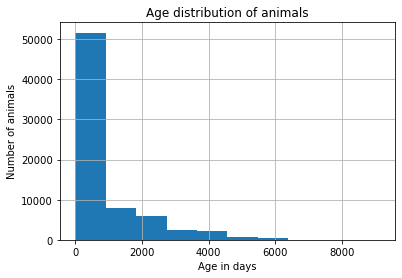

In [9]:
# Histogram of number of pets within a certain age range
df['age_upon_outcome'].hist()
plt.title("Age distribution of animals")
plt.xlabel("Age in days")
plt.ylabel("Number of animals")

In [10]:
# map the outcome to either adopted == 1 or not adopted == 0 to help our model 
outcomes = {
    'Transfer' : 0, 
    'Adoption' : 1, 
    'Euthanasia' : 0, 
    'Return to Owner' : 1, 
    'Died' : 0,
    'Disposal' : 0, 
    'Relocate' : 0, 
    'Missing' : 0, 
    'Unknown' : 0, 
    'Rto-Adopt' : 1
}

df['mapped_outcome_type'] = df['outcome_type'].map(outcomes)

In [11]:
# Here we handle outlier category names by changing them to general names
df['color'].loc[df['color'].str.contains('/')] = 'Mixed'
df['color'].loc[df['color'].str.contains('Blue')] = 'Blue'
df['color'].loc[df['color'].str.contains('Black')] = 'Black'
df['color'].loc[df['color'].str.contains('Brown')] = 'Brown'
df['color'].loc[df['color'].str.contains('Chocolate')] = 'Brown'
df['color'].loc[df['color'].str.contains('Point')] = 'Point Coloration'
df['color'].loc[df['color'].str.contains('Red')] = 'Red'
df['color'].loc[df['color'].str.contains('Cream')] = 'Cream'
df['color'].loc[df['color'].str.contains('Orange Tiger')] = 'Orange'
df['color'].loc[df['color'].str.contains('Silver')] = 'Gray'
df['color'].loc[df['color'].str.contains('Liver')] = 'Red'
df['color'].loc[df['color'].str.contains('Yellow')] = 'Yellow'
df['color'].loc[df['color'].str.contains('Tricolor')] = 'Mixed'
df['color'].loc[df['color'].str.contains('Fawn')] = 'Tan'
df['color'].loc[df['color'].str.contains('Calico')] = 'Mixed'
df['color'].loc[df['color'].str.contains('Torbie')] = 'Mixed'
df['color'].loc[df['color'].str.contains('Orange')] = 'Orange'
df['color'].loc[df['color'].str.contains('Gray')] = 'Gray'
df['color'].loc[df['color'].str.contains('Apricot')] = 'Cream'
df['color'].loc[df['color'].str.contains('Buff')] = 'Yellow'
df['color'].loc[df['color'].str.contains('Sable')] = 'Red'
df['color'].loc[df['color'].str.contains('Agouti')] = 'Mixed'

C:\Users\Andrew\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [12]:
# list of unique color categories
df['color'].unique()

array(['Orange', 'Mixed', 'White', 'Brown', 'Black', 'Yellow',
       'Point Coloration', 'Blue', 'Tan', 'Red', 'Cream', 'Tortie',
       'Gold', 'Gray', 'Green', 'Pink'], dtype=object)

In [13]:
# there are 16 unique color categories
len(list(df['color'].unique()))

16

**In the above code, I reduced the number of color categories from 500+ to 16. This will help our model and reduce the amount of 'noise'. Also, a new column was formed called 'mapped_outcome_type' which reduced the different types of outcomes to either 1 == adopted or 0 == not adopted.**

In [14]:

from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# label encoding the categorical variables that will be used for the classification models
df['color_code'] = labelencoder.fit_transform(df['color'])
df['animal_code'] = labelencoder.fit_transform(df['animal_type'])
df['sex_code'] = labelencoder.fit_transform(df['sex_upon_outcome'])

In [15]:
df = df[df['age_upon_outcome'].notna()]
df.isnull().sum()

age_upon_outcome           0
animal_id                  0
animal_type                0
breed                      0
color                      0
date_of_birth              0
datetime                   0
monthyear                  0
name                   16914
outcome_subtype        41639
outcome_type               0
sex_upon_outcome           0
mapped_outcome_type        0
color_code                 0
animal_code                0
sex_code                   0
dtype: int64

## Naive Bayes Model
This model performs well with categorical input variables and it is quick to predict so it was an easy choice for this data.

In [16]:
# define X and y
X = df[['color_code', 'age_upon_outcome', 'animal_code', 'sex_code']]
y = df['mapped_outcome_type']

In [17]:
# split X and y into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [18]:
# training the logistic regression model on the training set
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [19]:
# make class predictions for the testing set
y_pred_class = nb.predict(X_test)


array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [23]:
pd.Series(y_pred_class)
y_test.head()
temp = pd.concat([y_test,pd.Series(y_pred_class)], axis=1).dropna()
temp

,mapped_outcome_type,0
12,1.0,0.0
14,1.0,1.0
22,1.0,1.0
24,0.0,1.0
32,1.0,0.0
...,...,...
14188,0.0,1.0
14191,0.0,1.0
14200,1.0,1.0
14202,1.0,1.0


**Classification accuracy:** percentage of correct predictions

In [24]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7895996059390613


**Confusion Matrix:** a table that describes the performance of a classification model

In [25]:
print(metrics.confusion_matrix(y_test, y_pred_class))

[[2288 2415]
 [ 575 8933]]


In [26]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred_class)
TP = conf_matrix[1,1]
TN = conf_matrix[0,0]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]

In [27]:
print((TP+TN)/ float(TP + TN + FP + FN))
print (metrics.accuracy_score(y_test, y_pred_class))

0.7895996059390613
0.7895996059390613


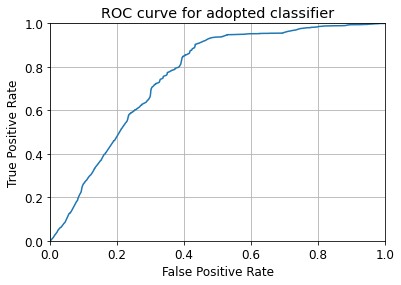

In [42]:
y_pred_prob = nb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title("ROC curve for adopted classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
print("AUC: " + (metrics.roc_auc_score(y_test, y_pred_prob)))

## AUC:
The percentage of the ROC plot that is underneath of the curve. AUC is useful indicator for classifier performance where the higher the value, the better the classifier. AUC represents the probability that the classifier will assign a higher predicted value to the positive observation.

In [47]:
print("AUC: ", (metrics.roc_auc_score(y_test, y_pred_prob)))

AUC:  0.7599832892493097


## K-Nearest Neighbor Model
This model was chosen simply for its easy implementation and quick results. In contrast to the next model, SVM, I was able to see my results instantly with KNN. 

In [52]:
# define X and y
X = df[['color_code', 'age_upon_outcome', 'animal_code', 'sex_code']]
y = df['mapped_outcome_type']

# split X and y into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [50]:
from sklearn.neighbors import KNeighborsClassifier
# number of neighbors always negative, choose wisely :D
kmodel = KNeighborsClassifier(n_neighbors = 7)
#fit model
kmodel.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [53]:
from sklearn import metrics

y_pred_class = kmodel.predict(X_test)
# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.roc_auc_score(y_test, y_pred_class))

0.7862219407501232
0.7267129078539992


**Can we improve the model by changing the number of required neighbors??**

In [55]:
from sklearn.neighbors import KNeighborsClassifier
# number of neighbors always negative, choose wisely :D
kmodel = KNeighborsClassifier(n_neighbors = 9)
#fit model
kmodel.fit(X_train, y_train)

from sklearn import metrics

y_pred_class = kmodel.predict(X_test)
# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.roc_auc_score(y_test, y_pred_class))

0.7889662937161354
0.723068663106847


In [56]:
from sklearn.neighbors import KNeighborsClassifier
# number of neighbors always negative, choose wisely :D
kmodel = KNeighborsClassifier(n_neighbors = 11)
#fit model
kmodel.fit(X_train, y_train)

from sklearn import metrics

y_pred_class = kmodel.predict(X_test)
# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.roc_auc_score(y_test, y_pred_class))

0.7927661670536909
0.7283261290714732


In [60]:
 from sklearn.neighbors import KNeighborsClassifier
# number of neighbors always negative, choose wisely :D
kmodel = KNeighborsClassifier(n_neighbors = 15)
#fit model
kmodel.fit(X_train, y_train)

from sklearn import metrics

y_pred_class = kmodel.predict(X_test)
# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.roc_auc_score(y_test, y_pred_class))

0.7969882485398635
0.7269145018025266


## Support Vector Machines (SVM) Model
Despite the long response time in generating results, the SVM model was chosen because it performs well when there is clear seperation between the classes of data, which we have here.

In [61]:
# define X and y
X = df[['color_code', 'age_upon_outcome', 'animal_code', 'sex_code']]
y = df['mapped_outcome_type']

# split X and y into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [64]:
from sklearn import svm

svmodel = svm.SVC()

#fit model
svmodel.fit(X_train, y_train)

#make prediction for the testing set
y_pred_class = svmodel.predict(X_test)

In [65]:
#calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.roc_auc_score(y_test, y_pred_class))

0.6689888114840616
0.49994741270509047


# And the best performance model is... **K-Nearest Neighbor** !!!
**K-Nearest Neighbor provided the highest accuracy scores, when using the value k = 15**

Overall, the K-Nearest Neighbor model is an 'okay' model. The AUC score is 0.7269145018025266 which represents the probability that the classifier will assign a higher predicted value to the positive observation. This value is considered a better representation for the quality of the classification model and it is lower than the accuracy score. Althought, the accuracy score gives us a representation of the percentage of correct predictions. This score is 0.7969882485398635, so nearly 80%. Therefore, I would not consider the model good, but simply 'okay' or average.